In [1]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np

from src.modules.preprocessing import image_loader

from src.modules.models import mobilenet_v2
from src.modules.models import mobilenet_v2_finetune

from src.modules.visualization import plot_images
from src.modules.visualization import model_metrics
from src.modules.visualization import plot_image_prediction
from src.modules.visualization import plot_value_array
from src.modules.visualization import image_metrics

## Data Preprocessing

In [2]:
BASE_DIR = 'data/275_Bird_Species/birds'
batch_size = 64
img_height = 224
img_width = 224
num_classes = 275

In [3]:
train_ds, val_ds, test_ds = image_loader(BASE_DIR, batch_size=batch_size)

Found 39364 files belonging to 275 classes.
Found 1375 files belonging to 275 classes.
Found 1375 files belonging to 275 classes.


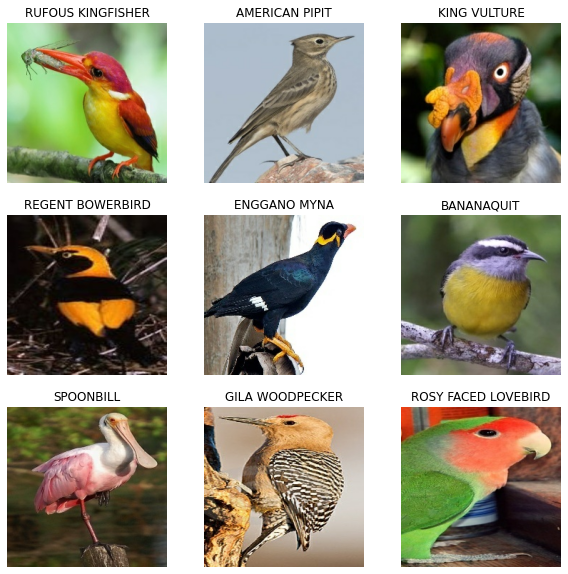

In [4]:
plot_images(train_ds)

In [5]:
# Increase performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_ds.prefetch(buffer_size=AUTOTUNE)

## MobileNetV2 model

In [7]:
base_model, model = mobilenet_v2(num_classes=num_classes, dropout=0.4, lr=0.01)

In [8]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 275)               352275

In [10]:
len(model.trainable_variables)

2

## Model Training

In [11]:
epochs = 20

history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds)

Epoch 1/20
616/616 [==============================] - 72s 111ms/step - loss: 1.8396 - accuracy: 0.6795 - val_loss: 0.6089 - val_accuracy: 0.8851
Epoch 2/20
616/616 [==============================] - 68s 111ms/step - loss: 1.1656 - accuracy: 0.8110 - val_loss: 0.5590 - val_accuracy: 0.8989
Epoch 3/20
616/616 [==============================] - 68s 110ms/step - loss: 0.9978 - accuracy: 0.8460 - val_loss: 0.6224 - val_accuracy: 0.9069
Epoch 4/20
616/616 [==============================] - 68s 110ms/step - loss: 0.9276 - accuracy: 0.8630 - val_loss: 0.4637 - val_accuracy: 0.9287
Epoch 5/20
616/616 [==============================] - 68s 110ms/step - loss: 0.8978 - accuracy: 0.8744 - val_loss: 0.5549 - val_accuracy: 0.9244
Epoch 6/20
616/616 [==============================] - 67s 109ms/step - loss: 0.8367 - accuracy: 0.8848 - val_loss: 0.5865 - val_accuracy: 0.9360
Epoch 7/20
616/616 [==============================] - 67s 109ms/step - loss: 0.8158 - accuracy: 0.8933 - val_loss: 0.5749 - val_ac

## Evaluation

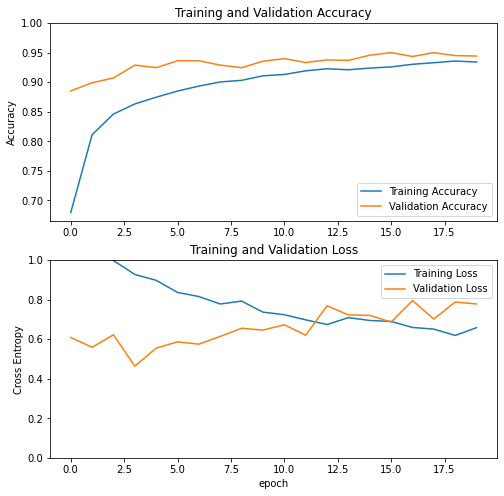

In [12]:
model_metrics(history)

In [13]:
test_loss, test_acc = model.evaluate(test_ds, verbose=2)

22/22 - 2s - loss: 0.5452 - accuracy: 0.9520


In [14]:
#model.save('MN_model_95.h5')

## Unfreeze some layers for further tuning

In [16]:
base_model, model = mobilenet_v2_finetune(base_model, model, layers_to_tune=50, lr=0.000001)

In [17]:
more_epochs = 10
epochs =  epochs + more_epochs

history = model.fit(train_ds,
                    epochs=epochs,
                    initial_epoch=history.epoch[-1],
                    validation_data=val_ds)

Epoch 20/30
616/616 [==============================] - 111s 176ms/step - loss: 0.4540 - accuracy: 0.9470 - val_loss: 0.5220 - val_accuracy: 0.9556
Epoch 21/30
616/616 [==============================] - 107s 174ms/step - loss: 0.3370 - accuracy: 0.9529 - val_loss: 0.4586 - val_accuracy: 0.9571
Epoch 22/30
616/616 [==============================] - 108s 175ms/step - loss: 0.2898 - accuracy: 0.9574 - val_loss: 0.4347 - val_accuracy: 0.9549
Epoch 23/30
616/616 [==============================] - 107s 174ms/step - loss: 0.2607 - accuracy: 0.9598 - val_loss: 0.4027 - val_accuracy: 0.9556
Epoch 24/30
616/616 [==============================] - 108s 174ms/step - loss: 0.2428 - accuracy: 0.9605 - val_loss: 0.3792 - val_accuracy: 0.9593
Epoch 25/30
616/616 [==============================] - 107s 174ms/step - loss: 0.2374 - accuracy: 0.9617 - val_loss: 0.3800 - val_accuracy: 0.9571
Epoch 26/30
616/616 [==============================] - 106s 172ms/step - loss: 0.2200 - accuracy: 0.9613 - val_loss: 0

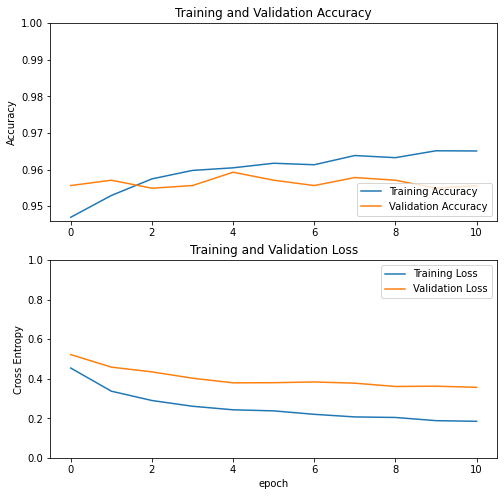

In [18]:
model_metrics(history)

In [19]:
test_loss, test_acc = model.evaluate(test_ds, verbose=2)

22/22 - 2s - loss: 0.2593 - accuracy: 0.9665


In [20]:
#model.save('MN_model_96.h5')

## Image Evaluation Visualization

In [4]:
loaded_model = tf.keras.models.load_model('MN_model_96.h5')

In [5]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 275)               352275

/tf/Final_Project/src/modules/visualization.py:109: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


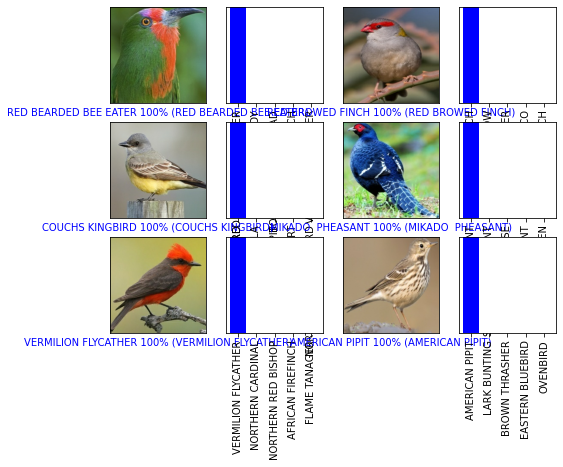

In [6]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = loaded_model.predict_on_batch(image_batch)

class_names = test_ds.class_names
num_rows = 3
num_cols = 2

image_metrics(num_rows, num_cols, predictions, label_batch, image_batch, class_names)